<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>

## Basic PreProcessing operations in  Geo Dataframes

We will review some important formatting processes for geodataframes. As usual, let's do this: 

1. Create a repository named: **geodfprepro**.
2. Clone that repo to a local folder in your computer.
3. In that local folder in your computer, create a folder named **maps** and **data**.
4. Put the **brazilMaps_5641.gpkg**  file that contains the three maps prepared last class into the map folder.
5. Commit and push: get the link for the **brazilMaps_5641.gpkg** from **geodfprepro** repo in GitHub cloud.

Let's read the file with the help of **geopandas**:

In [6]:
import os


import geopandas as gpd
from  fiona import listlayers

#maps
brazilMaps='https://github.com/CienciaDeDatosEspacial/geodfprepro/raw/main/maps/brazilMaps_5641.gpkg'

#layers in maps
listlayers(brazilMaps)

['country', 'cities', 'rivers']

Retrieving each map (layer):

In [7]:
brazil=gpd.read_file(brazilMaps,layer='country')
brazil_cities=gpd.read_file(brazilMaps,layer='cities')
brazil_rivers=gpd.read_file(brazilMaps,layer='rivers')

Making sure they have the same CRS:

In [8]:
brazil.crs.to_epsg()==brazil_cities.crs.to_epsg()==brazil_rivers.crs.to_epsg()

True

Mapping:

<Axes: >

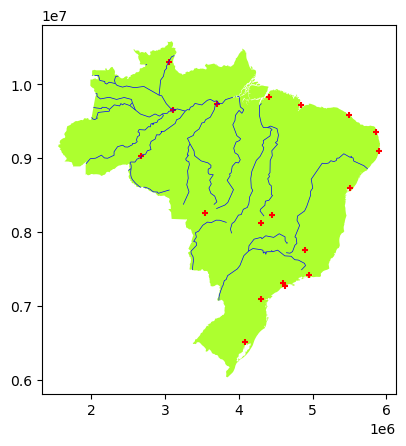

In [9]:
# plotting
base = brazil.plot(facecolor="greenyellow")
brazil_rivers.plot(edgecolor='blue', linewidth=0.5,ax=base)
brazil_cities.plot(marker='+', color='red', markersize=15,ax=base)

Now, let's see some important pre processing operations:

1. [(Re) Projecting](#1)
    * [Geoseries projections](#1_1)
    * [Lack of Projection](#1_2)
    
2. [Dissolving](#2)
3. [Creating Spatial Points](#3)
    * [Creating a convex hull](#31)
4. [Checking Validity](#4)



<a class="anchor" id="1"></a>

## (Re) Projecting  

As mentioned in class, the CRS is a very important property of the maps. They affect three aspects:

* shape
* area
* scale
* direction

The most used CRS is 4326, but it is **not projected**:

In [ ]:
# unit is in degrees:
brazil.crs.axis_info

Some operations will **warn** you on this issue:

In [ ]:
# centroid
brazil.centroid

A projected CRS will have units in meters or feet (or similar):

In [ ]:
brazil.to_crs(3587).crs.axis_info

In [ ]:
# operations that require projected CRS will work:
brazil.to_crs(3587).centroid

In [ ]:
# plot this projected version

base3587=brazil.to_crs(3587).plot()
brazil.to_crs(3587).centroid.plot(color='red',ax=base3587)

We use the crs **3587** as an emergency option to reproject a map. However, for a more accurate option it is better to look for the ones explicitly prepared for a particular locations of the world. 

In [ ]:
# recommended for Brazil (meters)
brazil.to_crs(5641).crs.axis_info

In [ ]:
# this works
brazil.to_crs(5641).centroid

In [ ]:
# replotting:

base5641=brazil.to_crs(5641).plot()
brazil.to_crs(5641).centroid.plot(color='red',ax=base5641)

Not using the right projection will give you a wrong numerical result when needing numerical accuracy; however, you might find situation where the visual output seems right (yet it is wrong):

In [ ]:
from matplotlib import pyplot

fig, (ax1, ax2) = pyplot.subplots(ncols=2, sharex=False, sharey=False, figsize=(12,12))

ax1.set_title('projected (5641)',fontsize=10)
brazil.to_crs(5641).plot(ax=ax1)
brazil.to_crs(5641).centroid.plot(color='red',ax=ax1)

ax2.set_title('unprojected',fontsize=10)
brazil.plot(ax=ax2)
brazil.centroid.plot(color='red',ax=ax2)


Let's keep the projected version for all our maps:

In [ ]:
brazil_5641=brazil.to_crs(5641)
# just Brazil

cities_5641=cities.to_crs(brazil_5641.crs)
cities_5641=cities_5641[cities_5641.COUNTRY=='Brazil']

rivers_5641=rivers.to_crs(brazil_5641.crs)
rivers_5641=gpd.clip(gdf=rivers_5641,mask=brazil_5641)

We could save these maps on Brazil:

In [ ]:
# saving 
import os

brazil_5641.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='country', driver="GPKG")
cities_5641.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='cities', driver="GPKG")
rivers_5641.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='rivers', driver="GPKG")

### Exercise 1

<div class="alert-success">
    
1. Compute the centroid of your country map.

2. If you get a warning in the previous step, detect the current projection. If there is no CRS information at all, STOP. If you get a CRS, continue.

3. Look for the right CRS for your map, so that you get a projected map.

4. Reset the CRS.

5. Plot both the reprojected map and its centroid.
    
</div>

<a class="anchor" id="1_1"></a>
### Formating Geoseries projections

You know **brazil_5641** is a multipolygon:

In [ ]:
brazil_5641

Sometime, you just need the border (lines):

In [ ]:
brazil_5641.boundary

In [ ]:
# This is just the borderline
brazil_5641.boundary.plot()

Always check the data type:

In [ ]:
# does 'boundary' return a GDF?
type(brazil_5641.boundary)

Some operations in geopandas require GDF or GS. If you need a GDF instead of a GS:

In [ ]:
# converting into GDF
brazil_5641.boundary.to_frame()

Notice you get a very simple GDF, and you may want to add some info:

In [ ]:
# conversion
brazil_5641DF=brazil_5641.boundary.to_frame() 

# new column (optional)
brazil_5641DF['name']='Brazil' 

# renaming the geometry column
brazil_5641DF.rename(columns={0:'geometry'},inplace=True) 

#setting the geometry (the name is not enough)
brazil_5641DF = brazil_5641DF.set_geometry("geometry")

# verifying:
brazil_5641DF.crs

You can add this GDF as a layer:

In [ ]:
brazil_5641DF.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='border', driver="GPKG")

### Exercise 2

<div class="alert-success"> 
    
1. Select one of **your** GDFs with several polygons.
    
2. Recover just the boundaries of that GDF.
    
3. Turn the boundary into a GDF.
</div>

<a class="anchor" id="1_2"></a>

### Lacking CRS information

Reprojecting seems a simple process, but you might find some interesting cases. Download the shapefile of Brazil - Subnational Administrative Boundaries from [here](https://data.humdata.org/dataset/cod-ab-bra) and save it in the maps folder (you need to unzip the file).

In [ ]:
brazil_states=gpd.read_file(os.path.join("maps","bra_adm_ibge_2020_shp","bra_admbnda_adm1_ibge_2020.shp"))
brazil_municipalities=gpd.read_file(os.path.join("maps","bra_adm_ibge_2020_shp","bra_admbnda_adm2_ibge_2020.shp"))

Notice this:

In [ ]:
brazil_states.crs, brazil_municipalities.crs

They do not have crs information, however:

In [ ]:
fig, (ax1, ax2) = pyplot.subplots(ncols=2, sharex=False, sharey=False, figsize=(12,12))

brazil_states.plot(ax=ax1, facecolor='lightgrey', edgecolor='black')
brazil_municipalities.plot(ax=ax2, facecolor='lightgrey', edgecolor='black',linewidth=0.2)


Since we are using the crs 5641 for Brazil:

In [ ]:
brazil_states.to_crs(5641)

Python says _"Please set a crs on the object first"_. This would mean to know the actual projection, of the geometry:

In [ ]:
brazil_states.geometry

From the plots above, it looks like an unprojected map, then:

In [ ]:
brazil_states.crs = "EPSG:4326"
brazil_municipalities.crs = "EPSG:4326"

Now, we can reproject:

In [ ]:
brazil_states_5641=brazil_states.to_crs(5641)
brazil_municipalities_5641=brazil_municipalities.to_crs(5641)

We update the file:

In [ ]:
brazil_states_5641.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='states', driver="GPKG")
brazil_municipalities_5641.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='municipalities', driver="GPKG")

### Exercise 3

<div class="alert-success">

1. Check all the CRSs of your GDFs.

2. If you find one CRS is missing, fill the CRS with the right projection.
</div>

<a class="anchor" id="2"></a>

## Dissolving

We have subset the map using clip (subset respect to another map boundaries). You can also subset using _loc_ or _iloc_ (from pandas); let me now subset using   geopandas'  **cx** to do subsetting **by location**:

In [ ]:
centroBrazil=brazil_5641.centroid


fig, axs = pyplot.subplots(nrows=2,ncols=2,sharex=False, sharey=False,figsize=(8,8))

axs[0,0].set_title('Above_Centroid, LeftOf_Centroid',fontsize=5)
brazil_municipalities_5641.cx[:centroBrazil.x,centroBrazil.y:].plot(ax=axs[0,0]) 

axs[0,1].set_title('Above_Centroid, RightOf_Centroid',fontsize=5)
brazil_municipalities_5641.cx[centroBrazil.x:,centroBrazil.y:].plot(ax=axs[0,1]) 

axs[1,0].set_title('Below_Centroid, LeftOf_Centroid',fontsize=5)
brazil_municipalities_5641.cx[:centroBrazil.x,:centroBrazil.y].plot(ax=axs[1,0]) 

axs[1,1].set_title('Below_Centroid, RightOf_Centroid',fontsize=5)
brazil_municipalities_5641.cx[centroBrazil.x:,:centroBrazil.y].plot(ax=axs[1,1]) 

You can create a polygon with one of these:

In [ ]:
#instead of:
brazil_municipalities_5641.cx[:centroBrazil.x,centroBrazil.y:]

In [ ]:
# you create
Brazil_topLeft=brazil_municipalities_5641.cx[:centroBrazil.x,centroBrazil.y:].dissolve()
# you get
Brazil_topLeft

Aside from the geometry column, the rest in wrong, then:

In [ ]:
Brazil_topLeft['zone']='NW'
Brazil_topLeft=Brazil_topLeft.loc[:,['ADM0_EN','zone','geometry']]   
Brazil_topLeft

In [ ]:
# this is the plot

Brazil_topLeft.plot()

Keep in mind that with **CX** you may not get a perfect partition:

In [ ]:

rowsCX=(brazil_municipalities_5641.cx[:centroBrazil.x,centroBrazil.y:].shape[0],\
brazil_municipalities_5641.cx[centroBrazil.x:,centroBrazil.y:].shape[0],\
brazil_municipalities_5641.cx[:centroBrazil.x,:centroBrazil.y].shape[0],\
brazil_municipalities_5641.cx[centroBrazil.x:,:centroBrazil.y].shape[0])
sum(rowsCX)

So, you have duplicated polygons across the zones:

In [ ]:
sum(rowsCX)-brazil_municipalities_5641.shape[0]

### Exercise 4


<div class="alert-success"> 

1. Compute the centroid of your country.

2. Dissolve all the polygons to the north, and also all the polygons to the south. Plot both results.

3. Detect the amount of duplicates after the dissolving process.
    
</div>

<a class="anchor" id="3"></a>

## Creating Spatial data

You will get Lines and Polygons as maps for sure, but that may not be the case with points. Let me download a **CSV** file with information on the airports in Brazil from this [website](https://data.humdata.org/dataset/ourairports-bra), I will save it in my **data** folder:

In [ ]:
import pandas as pd 
infoairports=pd.read_csv(os.path.join("data","br-airports.csv"))

# some rows

infoairports.iloc[[0,1,2,3,-4,-3,-2,-1],:] #head and tail

This needs some cleaning:

In [ ]:
# bye first row 
infoairports.drop(index=0,inplace=True)
infoairports.reset_index(drop=True, inplace=True)
infoairports.head()

In [ ]:
# keep the  columns needed

infoairports.columns.to_list()

In [ ]:
keep=['name','type','latitude_deg', 'longitude_deg','elevation_ft','region_name','municipality']
infoairports=infoairports.loc[:,keep]

In [ ]:
infoairports.info()

Some formatting:

In [ ]:
numericCols=['latitude_deg', 'longitude_deg','elevation_ft']
infoairports[numericCols]=infoairports.loc[:,numericCols].apply(lambda x:pd.to_numeric(x))

# now 
infoairports.info()

In [ ]:
# let's plot

base = brazil.plot(color='white', edgecolor='black') #unprojected

infoairports.plot.scatter(x = 'longitude_deg', y = 'latitude_deg',ax=base)

Would that be ok? It is supposed to be right. 


Let me turn those coordinates into a map of points:

In [ ]:
airports=gpd.GeoDataFrame(data=infoairports.copy(),
                 geometry=gpd.points_from_xy(infoairports.longitude_deg,
                                             infoairports.latitude_deg), 
                 crs=brazil.crs.to_epsg())# the coordinates were in degrees - unprojected

In [ ]:
# does it look better?

# let's plot

base = brazil.plot(color='white', edgecolor='black')
airports.plot(ax=base)

In [ ]:
#remember:
type(airports), type(infoairports)

Then this works:

In [ ]:
airports.to_crs(5641).plot()

In [ ]:
# this does not:
infoairports.to_crs(5641).plot()

Let's keep the projected version:

In [ ]:
airports_5641=airports.to_crs(5641)

Remember you have type of airports:

In [ ]:
airports_5641['type'].value_counts() # this will not work: airports.type.value_counts()

We may use that in the future. For now, just rename the **type** column to a different one.

In [ ]:
airports_5641.rename(columns={'type':'kind'},inplace=True)

That may be useful:

In [ ]:
from folium import LayerControl


m = airports_5641[airports_5641.kind=='small_airport'].explore(color="red",name="small",show=False)
m = airports_5641[airports_5641.kind=='medium_airport'].explore(m=m, color="blue",name="medium",show=False)
m = airports_5641[airports_5641.kind=='large_airport'].explore(m=m, color="black",name="large",show=True)
m = airports_5641[airports_5641.kind=='seaplane_base'].explore(m=m, color="green",name="seaplane",show=False)
m = airports_5641[airports_5641.kind=='closed'].explore(m=m, color="white",name="closed",show=False)
m = airports_5641[airports_5641.kind=='heliport'].explore(m=m, color="orange",name="heliport",show=False)

LayerControl(collapsed=False).add_to(m) #optional

m

Now, let's add this map of points:

In [ ]:
airports_5641.to_file(os.path.join("maps","brazilMaps_5641.gpkg"),layer='airports', driver="GPKG")


### Exercise 5 (extra credit - optional)
<div class="alert-success">

1. Look for some points in a CSV file about your country.
    
2. Turn those points into a spatial object.
    
3. Save the layer.
    
</div>

<a class="anchor" id="31"></a>

## Creating the convex hull

Some time you may have the need to create a polygon that serves as an envelope to a set of points. As en envelope, it should have only convex angles. That envelope is the convex hull:

In [ ]:
# in a polygon
Brazil_topLeft

In [ ]:
Brazil_topLeft.plot()

In [ ]:
Brazil_topLeft.convex_hull

In [ ]:
Brazil_topLeft.convex_hull.plot()

Notice that the convex hull works for each row of the geometry. _Brazil_topLeft_ was one geometry row, so the convex hull was straightforward.

This might be different if you have points:

In [ ]:
large_airport=airports_5641[airports_5641.kind=='large_airport']
# several rows
large_airport

In this situation, as you want the convex hull of the large airports, you need to combine all the points:

In [ ]:
large_airport.unary_union

This is a **multipoint** geometry:

In [ ]:
gpd.GeoSeries(large_airport.unary_union)

Then, you are ready to get the convex hull:

In [ ]:
large_airport.unary_union.convex_hull

Notice the type:

In [ ]:
type(large_airport.unary_union.convex_hull)

This will not work for a geometry:

In [ ]:
large_airport.unary_union.convex_hull.plot()

In [ ]:
# but it will for a series
gpd.GeoSeries(large_airport.unary_union.convex_hull).plot()

Let's turn the GS into a GDF:

In [ ]:
# as gdf
LargeAirport_hull=gpd.GeoSeries(large_airport.unary_union.convex_hull).to_frame()
LargeAirport_hull

In [ ]:
#next steps
LargeAirport_hull.rename(columns={0:'geometry'},inplace=True)
LargeAirport_hull['name']='large airports hull' # optional
LargeAirport_hull=LargeAirport_hull.set_geometry('geometry')
LargeAirport_hull.crs="EPSG:5641"
# verifying:
LargeAirport_hull.crs

Let's use the GDF in plotting:

In [ ]:
base=brazil_5641.plot(facecolor='yellow')
large_airport.plot(ax=base)
LargeAirport_hull.plot(ax=base,facecolor='green',
                       edgecolor='white',alpha=0.4,
                       hatch='X')

In [ ]:
LargeAirport_hull.explore()

### Exercise 6 

<div class="alert-success">

1. Select some points from your maps.
    
2. Create the convex hull for those points.
    
3. Turn the hull into a GDF.
    
4. Plot the hull on top of the country.
    
</div>

<a class="anchor" id="4"></a>

## Checking Validity of Geometry

Geometries are created in a way that some issues may appear, especially in (multi) polygons.
Let's check if our recent maps on states and municipalities are valid:

In [ ]:
# non valid
brazil_states_5641[~brazil_states_5641.is_valid]

In [ ]:
# see the invalid:
brazil_states_5641[~brazil_states_5641.is_valid].plot()

It is difficult to see what is wrong. Let's get some information:

In [ ]:
# what is wrong?

from shapely.validation import explain_validity, make_valid

explain_validity(brazil_states_5641[~brazil_states_5641.is_valid].geometry)

Let's solve the issue:

In [ ]:
BrSt5641_valid=brazil_states_5641[~brazil_states_5641.is_valid].copy()

# solving the issue:
BrSt5641_valid['geometry'] = [make_valid(row)  if not row.is_valid else row for row in BrSt5641_valid['geometry']]


In [ ]:
# any invalid?
BrSt5641_valid[~BrSt5641_valid.is_valid]

What about the other geodataframe?

In [ ]:
brazil_municipalities_5641[~brazil_municipalities_5641.is_valid]

In [ ]:
explain_validity(brazil_municipalities_5641[~brazil_municipalities_5641.is_valid].geometry)

In [ ]:
# varieties?
brazil_municipalities_5641['validity']=[x.split('[')[0] for x in brazil_municipalities_5641.geometry.apply(lambda x: explain_validity(x))]
brazil_municipalities_5641['validity'].value_counts()

In [ ]:
# solving the issue:
brazil_municipalities_5641.drop(columns=['validity'],inplace=True)

BrMun5641_valid=brazil_municipalities_5641.copy()

BrMun5641_valid['geometry'] = [make_valid(row)  if not row.is_valid else row for row in BrMun5641_valid['geometry'] ]
#any invalid?
BrMun5641_valid[~BrMun5641_valid.is_valid]

The _solution_ we got may help for some advanced techniques, but may also give us some extra trouble. Notice that once geopandas solved the problem, you  have created **collections**:

In [ ]:
[x for x in BrMun5641_valid["geometry"]]

Let's not save these last changes.

### Exercise 7 

<div class="alert-success">

1. Check if all your polygons are valid in every map you have (map of polygons only).
    
2. If you detect some invalid geometries, detect what the problem is.
    
3. Correct all cases. Do not save the results.
    
</div>